In [1]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from matplotlib import cm
from run import order

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
size = (7, 6)
start = 0
p = 1
dpi=200

In [4]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

In [5]:
# parser = argparse.ArgumentParser(
#     description="Plot the results of the chimera experiments")
# parser.add_argument(
#     "f", metavar="f", type=str, nargs=1,
#     help="The file of which we're making a plot."
# )
# file = parser.parse_args().f[0]

In [17]:
file = "../../data/0.041-0.021.pkl"

In [18]:
def similar(matrix, cortices, w=2):
    sim = np.empty([matrix.shape[0], matrix.shape[1] + w*(len(cortices) - 1)])
    sim[:] = np.nan
    for i, cortex in enumerate(cortices):
        sim[:, (cortex[0] + w*i):(cortex[1] + w*i)
            ] = matrix[:, cortex[0]:cortex[1]]
    return sim

In [19]:
current_cmap = cm.get_cmap()
current_cmap.set_bad(color='black')

In [20]:
metadata = pd.read_excel("../connectomes/mouse_meta.xlsx", sheet_name=None)
mtdt = metadata["Voxel Count_295 Structures"]
del(metadata)
mtdt = mtdt.loc[mtdt["Represented in Linear Model Matrix"] == "Yes"]
columns = []
cortices = [[0, 0]]
regions = mtdt["Major Region"].unique()
for region in regions:
    i = [columns.append(acronym.replace(" ", "")) for acronym in
         mtdt.loc[mtdt["Major Region"] == region, "Acronym"].values]
    cortices.append([cortices[-1][-1], cortices[-1][-1] + len(i)])
cortices.remove([0, 0])
del(mtdt)

In [21]:
with open(file, "rb") as f:
    [(b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2),
     sol, phase, χ, m] = pickle.load(f)

In [22]:
N = phase.shape[0]
plot_range = slice(int(start*N), int((start + p)*N))
phase = phase[plot_range]

In [23]:
y = sol.y.T.reshape(N, 3, -1)[int(start*N):int((start + p)*N), :, :]
del(sol)

In [24]:
title = f"$\\alpha$: {α:.03f}, $\\beta$: {β:.03f}, $\\chi$: {7*χ:.04f}, $m$: {12*m:.04f}"
title

'$\\alpha$: 0.041, $\\beta$: 0.021, $\\chi$: 0.5837, $m$: 0.9398'

In [25]:
means = np.zeros([len(cortices), phase.shape[0]])
sums = np.copy(means)

for i, cortex in enumerate(cortices):
    means[i] = np.mean(y[:, 0, cortex[0]:cortex[1]], axis=-1)
    sums[i] = np.sum(y[:, 0, cortex[0]:cortex[1]], axis=-1)

In [26]:
ρ_bar = np.mean(np.array([order(phase[:, low:high])
                          for [low, high] in cortices]),
                axis=0)

sigma = np.sum(np.array([(order(phase[:, low:high]) - ρ_bar)**2
                         for [low, high] in cortices]), axis=0)/len(cortices)

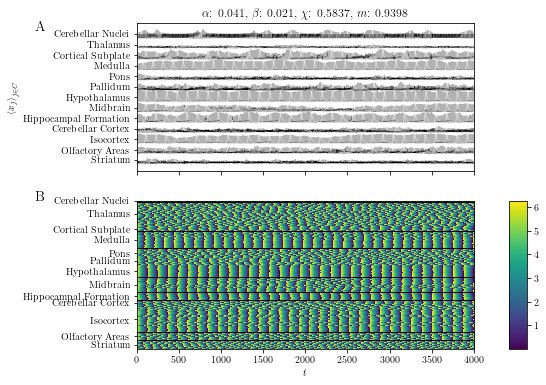

In [27]:
# BOTH
fig, [[means_ax, throwaway],
      [overhead_ax, cbar_ax]] = plt.subplots(nrows=2, ncols=2,
                                             gridspec_kw={"width_ratios":[95,5]}, figsize=size)

throwaway.axis("off")

for i, mn in enumerate(means):
    means_ax.plot(mn + 2.5*i, lw=0.15, color="k", rasterized=True)

means_ax.set_xlim([0, means.shape[1]])
means_ax.set_xticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000])
means_ax.set_xticklabels([])
means_ax.set_title(title)
means_ax.set_ylabel(r"$\expval{x_{j}}_{j \in C}$")

means_ax.set_yticks([2.5*i for i in range(len(regions))])
means_ax.set_yticklabels(regions)

means_ax.text(-0.3, 0.95, "A", transform=means_ax.transAxes, size="x-large")

overhead_im = overhead_ax.imshow(similar(phase, cortices, w=1).T, aspect="auto",
           origin="lower", interpolation="none", rasterized=True)
[i.set_linewidth(0.01) for i in plt.gca().spines.values()]
overhead_ax.set_xlim([0, phase.shape[0]])
overhead_ax.set_xticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000])
overhead_ax.set_xticklabels([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])
overhead_ax.set_yticks([cortex[0] + (cortex[1] - cortex[0])/2 + i for i, cortex in enumerate(cortices)])
overhead_ax.set_yticklabels(regions)
overhead_ax.set_xlabel("$t$")
plt.colorbar(overhead_im, cbar_ax)

overhead_ax.text(-0.3, 1, "B", transform=overhead_ax.transAxes, size="x-large")

plt.savefig(f"{α:.03f}-{β:.03f}_{dpi}dpi.pdf",
            dpi=dpi, bbox_inches="tight")

In [ ]:
# MEANS
for i, mn in enumerate(means):
    plt.plot(mn + 2.5*i, lw=0.15, color="k")

plt.xlim([0, means.shape[1]])
plt.xticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000],
           [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])
plt.title(title)
plt.xlabel("$t$")
plt.ylabel(r"$\expval{x_{j}}_{j \in C}$")

plt.yticks([2.5*i for i in range(len(regions))], regions)

fig = plt.gcf()
fig.set_size_inches(*size, forward=True)
fig.savefig(f"means-{α:.03f}-{β:.03f}.png", dpi=dpi,
            bbox_inches="tight", format="png")
plt.cla()
plt.clf()

In [ ]:
# OVERHEAD
plt.imshow(similar(phase, cortices, w=1).T, aspect="auto",
           origin="lower", interpolation="none")
[i.set_linewidth(0.01) for i in plt.gca().spines.values()]
plt.xlim([0, phase.shape[0]])
plt.xticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000],
           [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])
plt.yticks([cortex[0] + (cortex[1] - cortex[0])/2 + i for i, cortex in enumerate(cortices)], regions)
plt.title(title)
plt.colorbar()
fig = plt.gcf()
fig.set_size_inches(*size, forward=True)
plt.savefig(f"overhead-{α:.03f}-{β:.03f}.png",
            dpi=dpi, bbox_inches="tight", format="png")
plt.cla()
plt.clf()

In [ ]:
# COS(MEAN)
plt.plot(np.cos(np.mean(phase, axis=1)))
plt.title(title)
plt.xlim([0, phase.shape[0]])
plt.ylim([-1.05, 1.05])
plt.xlabel("time")
plt.ylabel("cos(mean(phase))")
fig = plt.gcf()
fig.set_size_inches(*size, forward=True)
plt.savefig(f"cos_mean-{α:.03f}-{β:.03f}.png",
            dpi=dpi, bbox_inches="tight", format="png")
plt.cla()
plt.clf()

In [ ]:
# COS(MEAN_I)
for cortex in cortices:
    [low, high] = cortex
    plt.plot(np.cos(np.mean(phase[:, low:high], axis=1)),
             label=f"{low + 1}-{high}", lw=0.05)
plt.xlim([0, phase.shape[0]])
plt.ylim([-1.05, 1.05])
plt.xlabel("time")
plt.ylabel("cos(mean(phi))")
plt.legend(bbox_to_anchor=(1, 1))
plt.title(title)
fig = plt.gcf()
fig.set_size_inches(*size, forward=True)
plt.savefig(f"by_cortex_cos_mean-{α:.03f}-{β:.03f}.png",
            dpi=500, bbox_inches="tight", format="png")
plt.cla()
plt.clf()

In [ ]:
# ORDER
plt.plot(order(phase))
plt.xlim([0, phase.shape[0]])
plt.ylim([-0.025, 1.025])
plt.xlabel("time")
plt.ylabel("rho")
plt.title(title)
fig = plt.gcf()
fig.set_size_inches(*size, forward=True)
plt.savefig(f"order-{α:.03f}-{β:.03f}.png", dpi=500,
            bbox_inches="tight", format="png")
plt.cla()
plt.clf()

In [ ]:
# SIGMA_I
for cortex in cortices:
    [low, high] = cortex
    plt.plot(((order(phase[:, low:high]) - ρ_bar)**2),
             label=f"{low + 1}-{high}", lw=0.05)
plt.xlim([0, phase.shape[0]])
plt.ylim([-0.05, 0.62])
plt.xlabel("time")
plt.ylabel("(rho - rho bar)**2")
plt.legend(bbox_to_anchor=(1, 1))
plt.title(title)
fig = plt.gcf()
fig.set_size_inches(*size, forward=True)
plt.savefig(f"by_cortex_variance-{α:.03f}-{β:.03f}.png",
            dpi=500, bbox_inches="tight", format="png")
plt.cla()
plt.clf()

In [ ]:
# SIGMA
plt.plot(sigma)
plt.xlim([0, phase.shape[0]])
plt.ylim([-0.01, 0.15])
plt.xlabel("time")
plt.ylabel("sigma(chi(t))")
plt.title(title)
fig = plt.gcf()
fig.set_size_inches(*size, forward=True)
plt.savefig(f"variance-{α:.03f}-{β:.03f}.png", dpi=500,
            bbox_inches="tight", format="png")
plt.cla()
plt.clf()

In [ ]:
xticks = [cortex[1] + 2*i + 1 for i, cortex in enumerate(cortices)][:-1]

In [ ]:
fig, [means_ax,
      overhead_ax,
      order_ax,
      cos_mean_ax,
      by_cortex_cos_mean_ax,
      variance_ax,
      by_cortex_variance_ax] = plt.subplots(7, 1, sharex=True, squeeze=True)

means_ax.set_title(title)

for i, mn in enumerate(means):
    means_ax.plot(mn + 2.5*i, lw=0.07, color="k")

means_ax.tick_params(axis="y",
                     left=False)
means_ax.set_yticklabels(["" for i in means_ax.get_yticks()])


[i.set_linewidth(0.01) for i in overhead_ax.spines.values()]
overhead_ax.set_xlim([0, phase.shape[0]])

overhead_ax.matshow(similar(phase, cortices, 2).T,
                    aspect="auto", origin="lower", interpolation="none")
overhead_ax.set_yticks(xticks)
overhead_ax.set_yticklabels(["" for i in xticks])
overhead_ax.tick_params(axis="y",
                        width=0.2)
overhead_ax.tick_params(axis="x",
                        top=False)


order_ax.plot(order(phase), lw=0.1)
order_ax.set_ylim([-0.025, 1.025])


cos_mean_ax.plot(np.cos(np.mean(phase, axis=1)), lw=0.1)
cos_mean_ax.set_ylim([-1.05, 1.05])


for cortex in cortices:
    [low, high] = cortex
    by_cortex_cos_mean_ax.plot(np.cos(np.mean(phase[:, low:high], axis=1)),
                               label=f"{low + 1}-{high}", lw=0.07)
by_cortex_cos_mean_ax.set_ylim([-1.05, 1.05])

variance_ax.plot(sigma, lw=0.1)
variance_ax.set_ylim([-0.01, 0.15])


for cortex in cortices:
    [low, high] = cortex
    by_cortex_variance_ax.plot(((order(phase[:, low:high]) - ρ_bar)**2),
                               label=f"{low + 1}-{high}", lw=0.07)
by_cortex_variance_ax.set_ylim([-0.05, 0.62])

fig.set_size_inches(*size, forward=True)
fig.savefig(f"all-{α:.03f}-{β:.03f}.png", dpi=700,
            bbox_inches="tight", format="png")
plt.cla()
plt.clf()